In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [97]:
%autoreload

import matplotlib
from matplotlib import cm
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
#import scipy

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import scipy.special

# import main as main

from tqdm import tqdm_notebook as tqdm

import pickle
import config
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import string
from datetime import datetime

# Bound-bound transitions

In [4]:
#~~~ BOUND_BOUND FUNCTIONS~~~

ZEROTEMP  = 1e-10   #/* (in eV) Treat temperatures below that threshold as being exactly zero */

#*************************************************# 
#A_{nl} coefficient defined in Hey (2006), Eq. (9)# 
#*************************************************#

def Hey_A(n, l):
    return np.sqrt(n**2-l**2)/(n*l)

#/*****************************************************************# 
#Absolute value of R_{n', n'- 1}^{n n'} as in Hey (2006), Eq. (B.4) 
#Assumes n > np.
#******************************************************************#

lgamma = scipy.special.loggamma
def Hey_R_initial(n, n_p):
#     return (-1)**(n-n_p-1) * 2**(2*n_p+2) * np.sqrt(
#         fact(n+n_p)/fact(n-n_p-1)/fact(2*n_p-1)) * (
#         n_p/n)**(n_p+2) * (1-n_p/n)**(n-n_p-2)/(1+n_p/n)**(n+n_p+2)
    return np.exp(
        (2.0*n_p + 2.0) * np.log(2.0) + 
        0.5 * (lgamma(n+n_p+1) - lgamma(n-n_p) - lgamma(2.0*n_p)) 
        + (n_p + 2.0) * np.log(n_p/n) 
        + (n-n_p - 2.0) * np.log(1.0 - n_p/n) - (n + n_p + 2.0) * np.log(1.0 + n_p/n)
    )

#/*********************************************************************
#Populates a matrix with the radial matrix elements.
#Inputs: two [nmax+1][nmax+1][nmax] matrices Rup, Rdn, nmax.
#Rup is populated s.t. R_up[n][n'][l] = R([n,l],[n',l+1])
#Rdn is populated s.t. R_dn[n][n'][l] = R([n,l],[n',l-1])
#Assumption: n > n'
#**********************************************************************/

def populate_radial(nmax):
    R_up = np.zeros((nmax+1,nmax,nmax))
    R_dn = np.zeros((nmax+1,nmax,nmax))
        
    for n in np.arange(2,nmax+1,1):
        for n_p in np.arange(1,n):
            #/* Initial conditions: Hey (2006) Eq. (B.4). */
            R_dn[n][n_p][n_p] = Hey_R_initial(n, n_p)
            R_up[n][n_p][n_p-1] = R_up[n][n_p][n_p] = 0
            for l in np.arange(n_p-1,0,-1):
                #/* Hey (52-53) */
                R_dn[n][n_p][l] = ((2*l+1) * Hey_A(n, l+1) * R_dn[n][n_p][l+1] 
                    + Hey_A(n_p, l+1) * R_up[n][n_p][l]) / (2.0 * l * Hey_A(n_p, l))
         
                R_up[n][n_p][l-1] = ((2*l+1) * Hey_A(n_p, l + 1) * R_up[n][n_p][l] 
                    + Hey_A(n, l+1) * R_dn[n][n_p][l+1]) / (2.0 * l * Hey_A(n, l))
    
    return {'up': R_up, 'dn': R_dn}

# /*************************************************************************************************************** 
# Populates two matrices with the bound-bound rates for emission and absorption, 
#  in a black-body radiation field.
# Inputs : two [nmax+1][nmax+1][nmax] matrices BB_up and BB_dn, nmax, Tr (IN EV !), 
#  and the two precomputed matrices of radial matrix elements R_up and R_dn.
# BB_up[n][n'][l] = A([n,l]-> [n',l+1]) * (1 + f(E_{nn'}))                if n > n'
#                 = (2l+3)/(2l+1) exp(-E_{nn'}/Tr) * BB_dn[n'][n][l+1]    if n < n'
# BB_dn[n][n'][l] = A([n,l]-> [n',l-1]) * (1 + f(E_{nn'}))                if n > n'      
#                 = (2l-1)/(2l+1) exp(-E_{nn'}/Tr) * BB_up[n'][n][l-1]    if n < n'             
#  *****************************************************************************************************************/

hplanck = phys.hbar*2*np.pi
def populate_bound_bound(nmax, Tr, R): 
    BB = {key: np.zeros((nmax+1,nmax+1,nmax)) for key in ['up', 'dn']}
    for n in np.arange(2,nmax+1,1):
        n2 = n**2
        for n_p in np.arange(1,n,1):
            n_p2 = n_p**2
            Ennp = (1/n_p2 - 1/n2) * phys.rydberg; 
            if (Tr < ZEROTEMP):    #/* if Tr = 0*/
                fEnnp = 0.0;
            else:
                fEnnp = np.exp(-Ennp/Tr)/(1-np.exp(-Ennp/Tr))
                #fEnnp = 1/(np.exp(Ennp/Tr)-1) 

            common_factor = 2*np.pi/3 * phys.rydberg / hplanck * (
                phys.alpha * (1/n_p2 - 1/n2))**3
            
            for l in np.arange(0,n_p+1,1): #/* Spont + stim emission */
                A_up = common_factor * (l+1) / (2*l+1) * R['up'][n][n_p][l]**2
                A_dn = common_factor *   l   / (2*l+1) * R['dn'][n][n_p][l]**2
                BB['up'][n][n_p][l] = A_up * (1+fEnnp)
                BB['dn'][n][n_p][l] = A_dn * (1+fEnnp)
                         
            BB['up'][n][n_p][n_p] = BB['up'][n][n_p][n_p-1] = 0.0   #/* No l' >= n' */
            BB['dn'][n][n_p][0]   = 0.0                          #/* No l' < 0   */
            for l in np.arange(0,n_p,1): #/* Absorption obtained by detailed balance */       
                if (Tr < ZEROTEMP):  #/* if Tr = 0 */
                    BB['up'][n_p][n][l] = BB['dn'][n_p][n][l+1] = 0.0;
                else:
                    BB['up'][n_p][n][l]   = (2*l+3)/(2*l+1) * np.exp(-Ennp/Tr) * BB['dn'][n][n_p][l+1]
                    BB['dn'][n_p][n][l+1] = (2*l+1)/(2*l+3) * np.exp(-Ennp/Tr) * BB['up'][n][n_p][l]
    
    return BB

# /********************** HL FUNCTION *******************************************************************************
# Populates two matrices with the bound-bound rates for emission and absorption, in an arbitrary radiation field.
# Note that Tr parametrizes the redshift: we assume that the spectrum is almost a blackbody with temperature Tr.
# Inputs : two [nmax+1][nmax+1][nmax] matrices BB_up and BB_dn, nmax, a photon_dist structure, 
#  *****************************************************************************************************************/

# void populate_bound_bound_nonBB(
#     double ***BB_up, double ***BB_dn, unsigned nmax, double Tr, photon_dist *dist, double ***R_up, double ***R_dn
# ){
#     /* If it is a blackbody, call the old function. */
#     if (dist->blackbody){
#         populate_bound_bound(BB_up, BB_dn, nmax, Tr, R_up, R_dn);
#     }
#     else{
#         unsigned l, n, np; 
#         double n2, np2, Ennp, rs, fEnnp, common_factor, A_up, A_dn; 
#         for (n = 2; n <= nmax; n++){
#             n2 = ((double) n) * ((double) n);
#             for (np = 1; np < n; np++){
#                 np2 = ((double) np) * ((double) np); 
#                 Ennp = (1.0 / np2 - 1.0 / n2) * EI;
#                 /* Calculate redshift, obtain the photon occupancy */
#                 rs = Tr/Tr0;
#                 fEnnp = dist->f_occup(Ennp, rs);
#                 common_factor = 2.0 * np.pi/3.0 * EI / hPlanck * pow(alpha_fs *(1.0 / np2 - 1.0 / n2), 3.0);
#                 for (l = 0; l <= np; l++){
#                     /* Spont + stim emission */
#                     A_up = common_factor * (l + 1.0) / (2.0 * l + 1.0) * R_up[n][np][l] * R_up[n][np][l];
#                     A_dn = common_factor *     l     / (2.0 * l + 1.0) * R_dn[n][np][l] * R_dn[n][np][l];
#                     BB_up[n][np][l] = A_up * (1.0 + fEnnp);
#                     BB_dn[n][np][l] = A_dn * (1.0 + fEnnp);
#                 BB_up[n][np][np] = BB_up[n][np][np-1] = 0.0;   /* No l' >= n' */
#                 BB_dn[n][np][0] = 0.0;                         /* No l' < 0   */
#                 for (l = 0; l < np; l++){
#                     #/* Replaced Boltzmann weight by f/(1+f) */   
#                     BB_up[np][n][l]   = (2.0 * l + 3.0) / (2.0 * l + 1.0) * (fEnnp / (1.0 + fEnnp)) * BB_dn[n][np][l+1];
#                     BB_dn[np][n][l+1] = (2.0 * l + 1.0) / (2.0 * l + 3.0) * (fEnnp / (1.0 + fEnnp)) * BB_up[n][np][l];


# Bound-free transitions

In [5]:
#~~~ BOUND_FREE FUNCTIONS ~~~

EI       = 13.5982860719383 #/*13.60569193 / (1.0 + me_mp)*/       /* Ionization energy of hydrogen in eV, accounting for reduced mass */
alpha_fs = 7.2973525376e-3                                                     #/* Fine structure constant */
hPlanck  = 4.13566733e-15                                                      #/* Planck's constant in eV*s */
cLight   = 2.99792458e10                                                       #/* Speed of light in cm/s */
mue      = 510720.762779219              #/*me / (1.0 + me_mp)*/               #/* Reduced mass of hydrogen in eV*/ 

# /*********************************************************************************************************************
# Populates two matrices with the coefficients g(n, l; kappa, l+1) and g(n, l; kappa, l-1).
# Input: two [nmax] matrices g_up and g_dn, n, kappa.
# The matrices are populated s.t. g_up[l] = g(n, l; kappa, l+1) 
#                                 g_dn[l] = g(n, l; kappa, l-1).
# Reference: Burgess A.,1965, MmRAS..69....1B, Eqs. (28)-(34). 
# **********************************************************************************************************************/

def populate_gnlk(nmax, n, kappa):
    gnk_up = np.zeros((nmax, len(kappa)))
    gnk_dn = np.zeros((nmax, len(kappa)))
    
    k2 = kappa**2
    n2 = n**2
        
    log_product = 0.0;
    
    for s in range(1, n+1):
        log_product = log_product + np.log(1.0 + s*s*k2)
    log_init = (0.5 * (np.log(np.pi/2) - lgamma(2.0 * n)) + np.log(4.0) + n * np.log(4.0 * n) + 0.5 * log_product
             - 0.5 * np.log(1.0 - np.exp(-2.0 * np.pi / kappa)) - 2.0 * np.arctan(n * kappa) / kappa 
             - (n + 2.0) * np.log(1.0 + n2 * k2))
    gnk_up[n-1] = np.exp(log_init)
    gnk_dn[n-1] = 0.5 * np.sqrt((1.0 + n2 * k2) / (1.0 + (n - 1.0) * (n - 1.0) * k2)) / n * gnk_up[n-1]
 
    if n > 1:
        gnk_up[n-2] = 0.5 * np.sqrt((2.0 * n - 1.0) * (1.0 + n2 * k2)) * gnk_up[n-1]    
        gnk_dn[n-2] = 0.5 * (4.0 + (n - 1.0) * (1.0 + n2 * k2)) * np.sqrt(
            (2.0 * n - 1.0) / (1.0 + (n - 2.0) * (n - 2.0) * k2)) / n * gnk_dn[n-1]  
        for l in range(n-1,1,-1): 
            l2 = l**2
            gnk_up[l-2] = 0.5 * (((4.0 * (n2 - l2) + l * (2.0 * l - 1.0) * (1.0 + n2 * k2)) * gnk_up[l-1]
                              - 2.0 * n * np.sqrt((n2 - l2) * (1.0 + (l + 1.0) * (l + 1.0) * k2)) * gnk_up[l])
                                / np.sqrt((n2 - (l - 1.0) * (l - 1.0)) * (1.0 + l2 * k2)) / n)
        
        for l in range(n-2,0,-1):  
            l2 = l**2;
            gnk_dn[l-1] = 0.5 * (((4.0 * (n2 - l2) + l * (2.0 * l + 1.0) * (1.0 + n2 * k2)) * gnk_dn[l]
                              - 2.0 * n * np.sqrt((n2 - (l + 1.0) * (l + 1.0)) * (1.0 + l2 * k2)) * gnk_dn[l+1])
                              / np.sqrt((n2 - l2) * (1.0 + (l - 1.0) * (l - 1.0) * k2)) / n)
    return np.transpose(gnk_up), np.transpose(gnk_dn)

# /********************************************************************************************
# k2[n][ik] because boundaries depend on n
#  ********************************************************************************************/

def populate_k2_and_g(nmax, TM):
    k2_tab = np.zeros((nmax+1,10 * (NBINS-1) + 11))
    g = {key: np.zeros((nmax+1,Nkappa,nmax)) for key in ['up', 'dn']}
    k2max = 7e2*TM/EI        

    for n in range(1,nmax+1):
        k2min = 1e-25/n/n
        bigBins = np.logspace(np.log10(k2min), np.log10(k2max), NBINS + 1)
#         for iBig in range(NBINS):
#             temp = np.linspace(bigBins[iBig], bigBins[iBig+1], 11)
#             for i in range(11):
#                 k2_tab[n][10 * iBig + i] = temp[i]
        iBig = np.arange(NBINS)
        temp = np.linspace(bigBins[iBig], bigBins[iBig+1], 11)
        for i in range(11):
            k2_tab[n][10 * iBig + i] = temp[i]
        ik = np.arange(10 * NBINS + 1)
        g['up'][n,ik], g['dn'][n,ik] = populate_gnlk(nmax, n, np.sqrt(k2_tab[n,ik]))  
    return k2_tab, g


# /******************************************************************************************* 
# 11 point Newton-Cotes integration.
# Inputs: an 11-point array x, an 11-point array f(x).
# Output: \int f(x) dx over the interval provided.
# ********************************************************************************************/

def Newton_Cotes_11pt(x, f):
    h = (x[10] - x[0])/10.0 #/* step size */

    return (5.0 * h * (16067.0 * (f[0] + f[10]) + 106300.0 * (f[1] + f[9]) 
                      - 48525.0 * (f[2] + f[8]) + 272400.0 * (f[3] + f[7])
                      - 260550.0 * (f[4] + f[6]) + 427368.0 * f[5]) / 299376.0)

# /********************************************************************************************* 
# Populating the photoionization rates beta(n, l, Tr)
# Input: beta[nmax+1][nmax], Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# *********************************************************************************************/

def populate_beta(TM, Tr, nmax, k2_tab, g):
    k2 = np.zeros((11, NBINS))
    int_b = np.zeros((11, NBINS))
    common_factor =  2.0/3.0 * alpha_fs**3 * EI/hPlanck
    beta = np.zeros((nmax+1,nmax))

    for n in range(1, nmax+1):
        n2 = n**2
        for l in range(n):
            iBin = np.arange(NBINS)
            for i in range(11):
                ik = 10 * iBin + i
                k2[i] = k2_tab[n][ik]
                if (Tr < 1e-10):      #/* Flag meaning TR = 0 */
                    int_b[i] = 0.0
                else:
                    int_b[i] = ((1.0 + k2[i]*n2)**3 / (np.exp(EI / Tr * (k2[i] + 1.0 / n2)) - 1.0) * 
                                  ((l + 1.0) * g['up'][n,ik,l] * g['up'][n,ik,l] 
                                   + l * g['dn'][n,ik,l] * g['dn'][n,ik,l]))
            beta[n][l] += np.sum(Newton_Cotes_11pt(k2, int_b))
            beta[n][l] *= common_factor / n2 / (2.0 * l + 1.0)
    return beta

# /********************************************************************************************* 
# Populating the recombination coefficients alpha(n, l, Tm, Tr) 
# Input: alpha[nmax+1][nmax], Tm, Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# *********************************************************************************************/


# /****************************************************************************************/

def populate_alpha(Tm, Tr, nmax, k2_tab, g):
    k2 = np.zeros((11, NBINS))
    int_a = np.zeros((11, NBINS))   
    common_factor = (2.0/3.0 * alpha_fs**3 * EI/hPlanck 
                     * (hPlanck**2 * cLight**2/(2.0 * np.pi * mue * Tm))**1.5)
    alpha = np.zeros((nmax+1,nmax))
    
    for n in range(1,nmax+1):
        n2 = n**2
        for l in range(n):
            iBin = np.arange(NBINS)
            for i in range(11):
                ik = 10 * iBin + i
                k2[i] = k2_tab[n][ik]
                int_a[i] = ((1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * EI / Tm) *
                             ((l + 1.0) * g['up'][n,ik,l] * g['up'][n,ik,l] 
                              + l * g['dn'][n,ik,l] * g['dn'][n,ik,l]))
                if Tr > 1e-10:
                    int_a[i] /= (1. - np.exp(-EI/Tr*(k2[i] + 1./n2)))
            alpha[n][l] += np.sum(Newton_Cotes_11pt(k2, int_a))
            alpha[n][l] *= common_factor / n2
    return alpha

# Cross-checks

In [6]:
# For calculating Sobolev optical depth
hplanck = phys.hbar*2*np.pi
#astro-ph/9912182 Eq. 40
def tau_np_1s(n, R, rs, xHI=None):
    l=1
    nu = (1 - 1/n**2) * phys.rydberg/hplanck
    lam = phys.c/nu
    if xHI == None:
        xHI = 1-phys.xHII_std(rs)
    nHI = xHI * phys.nH*rs**3
    pre = lam**3 * nHI / (8*np.pi*phys.hubble(rs))
    
    common_factor = 2*np.pi/3 * phys.rydberg / hplanck * (
        phys.alpha * (1 - 1/n**2))**3
    
    A_dn = common_factor * l/(2*l+1) * R['dn'][n][1][l]**2
    g = (2*l+1)/(2*l-1)
    return pre * A_dn * g 

# Eq. 41
def p_np_1s(n, R, rs, xHI=None):
    tau = tau_np_1s(n, R, rs, xHI=xHI)
    return (1-np.exp(-tau))/tau

In [7]:
def print_transition(init, alpha, beta, BB):
    # Tools to translate atomic orbital notation
    spectroscopic = ['s', 'p', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
    spec_dict = {spec: i for i,spec in enumerate(spectroscopic)}
        
    # For ionized state, we only care about recombinations
    if init == 'ion':
        # Calculate total rate to transition
        tot_rate = np.sum(alpha)  #np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])
        
        print('Recombination coefficients')
        print('total: ', str(tot_rate), 'cm^3 s^-1\n')
        #print('fractional:')
        
        for n in range(1,alpha.shape[0]):
            for l in range(n):
                print(str(n) + list(spec_dict.keys())[list(spec_dict.values()).index(l)], 
                      '  ', alpha[n][l])#/tot_rate)
        
    # Otherwise, we need to print all transitions and photoionizations
    else:
        n = int(init[0])
        l = spec_dict[init[1]]

        # Calculate total rate to transition
        tot_rate = np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])

        print(init+' transition/ionization rates\n')
        # Photoionization
        print('ionization: ', str(beta[n][l]), 's^-1')
        print('total transition: ', str(tot_rate), 's^-1\n')
        print('fraction of transitions:')

        # If in lowest angular momentum state, can only transition up
        # So just print one column
        if l==0:
            print('n', 'p')
            for n_p in np.arange(1,BB['up'].shape[0],1):
                print(n_p, '{:.2e}'.format(BB['up'][n][n_p][l]/tot_rate))
        else:
            # Angular momentum must change by one, 
            # so print a column for going up and a column for down
            print('n', spectroscopic[l-1], '        ', spectroscopic[l+1])

            # n_p enumerates the other n's to transition to
            for n_p in np.arange(1,BB['up'].shape[0],1):
                # If n = 1 or 2, there is only one angular momentum state to transition to: l = 0
                if n_p <=l:
                    print(n_p, '{:.2e}'.format(BB['dn'][n][n_p][l]/tot_rate))
                else:
                    print(n_p, '{0:.2e}   {1:.2e}'.format(BB['dn'][n][n_p][l]/tot_rate, 
                                                          BB['up'][n][n_p][l]/tot_rate))

        if (l==0) and (n==2):
            print('special case, 2s -> 1s: ', BB['dn'][2][1][0]/tot_rate)

In [607]:
### Starting parameters
rs=600
nmax=9

xHI = 1-phys.xHII_std(rs)
TM  = 1e4 * phys.kB
#Tr  = phys.TCMB(rs)
Tr  = TM
NBINS = 100
Nkappa = 10 * NBINS + 1

### POPULATE!!!!!

# Timing
starttime = datetime.now()
R = populate_radial(nmax)
BB = populate_bound_bound(nmax, Tr, R)
# I have checked that BB(2p->1s) is correct (1.5e-9 s^-1)
print((datetime.now() - starttime).total_seconds())

# Timing
starttime = datetime.now()
k2_tab, g = populate_k2_and_g(nmax, TM)
alpha = populate_alpha(TM, Tr, nmax, k2_tab, g)
beta = populate_beta(TM, Tr, nmax, k2_tab, g)
print((datetime.now() - starttime).total_seconds())

#Include sobolev optical depth
for n in np.arange(2,nmax+1,1):
#     print(n, p_np_1s(n, R, rs, xHI=xHI))
    BB['dn'][n][1][1] = p_np_1s(n, R, rs, xHI=xHI) * BB['dn'][n][1][1]
    
#Include forbidden 2s->1s transition
BB['dn'][2][1][0] = phys.width_2s1s_H

#I have checked that the Sobolev Optical Depth 
#for 2p-1s is correct for rs<=3e3 (up to 4th digit)  

0.007198
0.049301


/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: overflow encountered in exp


In [608]:
print_transition('2p', alpha, beta, BB)

2p transition/ionization rates

ionization:  843017.3201536705 s^-1
total transition:  16908507.39886368 s^-1

fraction of transitions:
n s          d
1 1.31e-07
2 0.00e+00   0.00e+00
3 1.56e-02   8.01e-01
4 2.78e-03   1.11e-01
5 9.58e-04   3.50e-02
6 4.47e-04   1.57e-02
7 2.48e-04   8.45e-03
8 1.53e-04   5.13e-03
9 1.01e-04   3.37e-03


In [609]:
print_transition('ion', alpha, beta, BB)

Recombination coefficients
total:  4.5139830818372326e-13 cm^3 s^-1

1s    1.5831892359884352e-13
2s    2.3672203336891894e-14
2p    5.417028490680996e-14
3s    8.607401274066884e-15
3p    2.2610086692540043e-14
3d    1.948109028538774e-14
4s    4.522904296012134e-15
4p    1.2394900095908927e-14
4d    1.4322134623257582e-14
4f    7.576636474055407e-15
5s    2.8289327818700243e-15
5p    7.91531933153571e-15
5d    1.0253221470174207e-14
5f    8.006084172608613e-15
5g    3.0951562047689528e-15
6s    1.9476720190814326e-15
6p    5.519213833024615e-15
6d    7.593153261536573e-15
6f    7.015567495044412e-15
6g    4.24069878660608e-15
6h    1.3135257120072426e-15
7s    1.424456494264993e-15
7p    4.0719652108578096e-15
7d    5.813668339345772e-15
7f    5.900604642341175e-15
7g    4.376166164232234e-15
7h    2.200303405574167e-15
7i    5.752731279723955e-16
8s    1.0863123718704626e-15
8p    3.1254173185499304e-15
8d    4.575753928777969e-15
8f    4.9303724271693936e-15
8g    4.116420978506796

In [610]:
# Compare to tables in 1965MmRAS..69...1B
# X = n^2 k^2
n2 = np.arange(nmax+1)**2

theta_up = np.transpose(np.transpose((1.0 + np.transpose(n2*np.transpose(k2_tab)))) 
                        * np.transpose(g['up']**2))
theta_dn = np.transpose(np.transpose((1.0 + np.transpose(n2*np.transpose(k2_tab)))) 
                        * np.transpose(g['dn']**2))

In [611]:
# Choose which n and l to compare to
test_n = 1
test_l = 0

# ~~~ Table 1 ~~~
# Interpolate so we can compare to the Xs shown in the table
theta_dn_interp = interp1d(test_n**2 * k2_tab[test_n], theta_dn[test_n,:,test_l], fill_value='extrapolate')
theta_up_interp = interp1d(test_n**2 * k2_tab[test_n], theta_up[test_n,:,test_l], fill_value='extrapolate')

Xs = [0.000,0.005,0.010,0.020,0.040,0.080,0.160,0.320,0.640,1.280,2.560,5.120,10.24,20.48,40.96]

print('X            dn            up')
for i, X in enumerate(Xs):
    print(f'{X:.3e}    {theta_dn_interp(X):.4e}    {theta_up_interp(X):.4e}')
print('\n\n')

# SUCCESS!!!


# ~~~ Table 2 ~~~
ts = [1e5, 64, 32, 16, 8, 4, 2, 1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1e-10]

k2 = np.zeros(11)
int_up = np.zeros(11)   
int_dn = np.zeros(11)

phi_up = np.zeros_like(ts)
phi_dn = np.zeros_like(ts)

n2 = test_n**2
print('t            dn          up')
for ind, t in enumerate(ts):
    for iBin in range(NBINS):
        for i in range(11):
            ik = 10 * iBin + i
            k2[i] = k2_tab[test_n][ik]
            int_up[i] = (15.789) * (1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * 15.789/t) * (test_l + 1.0) * g['up'][test_n][ik][test_l] * g['up'][test_n][ik][test_l]
            int_dn[i] = (15.789) * (1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * 15.789/t) * test_l * g['dn'][test_n][ik][test_l] * g['dn'][test_n][ik][test_l]
        phi_up[ind] += Newton_Cotes_11pt(k2, int_up)
        phi_dn[ind] += Newton_Cotes_11pt(k2, int_dn)
    if t < 1:
        phi_up[ind] /= t
        phi_dn[ind] /= t
    print(f'{t:.3e}    {phi_dn[ind]:.3e}    {phi_up[ind]:.3e}')

# Disagrees at very large values of t? but, otherwise, success!

X            dn            up
0.000e+00    1.8413e+00    7.3652e+00
5.000e-03    1.8260e+00    7.2678e+00
1.000e-02    1.8110e+00    7.1722e+00
2.000e-02    1.7814e+00    6.9860e+00
4.000e-02    1.7244e+00    6.6324e+00
8.000e-02    1.6184e+00    5.9940e+00
1.600e-01    1.4336e+00    4.9434e+00
3.200e-01    1.1473e+00    3.4770e+00
6.400e-01    7.8159e-01    1.9075e+00
1.280e+00    4.2669e-01    7.4935e-01
2.560e+00    1.8115e-01    2.0374e-01
5.120e+00    6.0765e-02    3.9731e-02
1.024e+01    1.6916e-02    6.0320e-03
2.048e+01    4.0930e-03    7.6334e-04
4.096e+01    8.9991e-04    8.5929e-05



t            dn          up
1.000e+05    0.000e+00    4.967e+02
6.400e+01    0.000e+00    1.827e+02
3.200e+01    0.000e+00    1.238e+02
1.600e+01    0.000e+00    7.804e+01
8.000e+00    0.000e+00    4.599e+01
4.000e+00    0.000e+00    2.559e+01
2.000e+00    0.000e+00    1.365e+01
1.000e+00    0.000e+00    7.076e+00
5.000e-01    0.000e+00    7.216e+00
2.500e-01    0.000e+00    7.289e+00
1.250e-01

### Spectrum from cascading to ground/continuum state

In [612]:
from config import load_data

### DarkHistory bins for photon energies
# binning = load_data('binning')
# photeng = binning['phot']

### Precise bins
#photeng = np.logspace(np.log10(0.044), np.log10(13.7), 5000)

### Exact energy bins
photeng = np.zeros((10,10))
for n1 in range(1,10):
    photeng[0,n1] = phys.rydberg / n1**2
    for n2 in range(1,n1):
        photeng[n1,n2] = phys.rydberg * ((1/n2)**2 - (1/n1)**2)
        
photeng = np.sort(np.unique(photeng))

# Get indices where alpha != 0 --> correspond to ground and excited states
nonzero_n, nonzero_l = alpha.nonzero()

# Make array that has the n of each excited state
ns = np.zeros(45)
counter = 0
for i in range(1,10):
    ns[counter:counter + i] = i
    counter += i

In [613]:
### Build probability matrix for single transition, P_ij
P_matrix = np.zeros((len(nonzero_n)+1, len(nonzero_n)+1))

# Ground and continuum states are sink states
P_matrix[0,0] = 1
P_matrix[-1,-1] = 1

for nl in range(1, len(nonzero_n)):
    # Find indices for possible states to transition to (l must change by 1)
    # Get the rates for transitioning to those states, as well as total rate
    if nonzero_l[nl] != 0:
        dn_inds = np.where(nonzero_l == nonzero_l[nl]-1)[0]
        dn_rates = BB['dn'][nonzero_n[nl], nonzero_n[dn_inds], nonzero_l[nl]]
    else:
        # If angular momentum is 0, can only transition up
        dn_rates = 0
        
    up_inds = np.where(nonzero_l == nonzero_l[nl]+1)[0]
    up_rates = BB['up'][nonzero_n[nl], nonzero_n[up_inds], nonzero_l[nl]]
    tot_rate = np.sum(up_rates) + np.sum(dn_rates) + beta[nonzero_n[nl]][nonzero_l[nl]]
    
    # Special 2s->1s transition
    if nl == 1:
        tot_rate += BB['dn'][2][1][0]
        P_matrix[1][0] = BB['dn'][2][1][0] / tot_rate
        
    # Normalize by total rate for each state to get probabilities instead of rates
    if nonzero_l[nl] != 0:
        P_matrix[nl][dn_inds] = dn_rates / tot_rate
    P_matrix[nl][up_inds] = up_rates / tot_rate
    P_matrix[nl][-1] = beta[nonzero_n[nl]][nonzero_l[nl]] / tot_rate

In [614]:
### Calculate probability of any state going to 1s after many transitions

# Vector of probabilities for single transition
Pto1s = P_matrix[1:-1,0]
PtoCont = P_matrix[1:-1,-1]

P_sub = P_matrix[1:-1,1:-1]
P_series = np.linalg.inv(np.identity(len(Pto1s)) - P_sub)

# Geometric series with single-transition matrix
Pto1s_many = np.dot(P_series, Pto1s)
PtoCont_many = np.dot(P_series, PtoCont)

print('Probability to be in 1s after many transitions:')
print(Pto1s_many)

print('\n')
print('Probability to be in continuum after many transitions:')
print(PtoCont_many)

print('\n')
print('Check these add up to 1, since there are no other sink states:')
print(Pto1s_many + PtoCont_many)

Probability to be in 1s after many transitions:
[2.29798609e-06 1.33620265e-06 1.25814958e-06 1.85768711e-06
 1.26714127e-06 1.24214346e-06 1.58379466e-06 1.33840380e-06
 1.14640531e-06 1.18575660e-06 1.51038345e-06 1.27059091e-06
 1.10718291e-06 1.04983709e-06 1.15643551e-06 1.51522961e-06
 1.21459517e-06 1.04833423e-06 9.86248983e-07 9.93253800e-07
 1.14199817e-06 1.58008141e-06 1.17915113e-06 9.99646233e-07
 9.28145100e-07 9.31064196e-07 9.66778603e-07 1.11660979e-06
 1.70953248e-06 1.16428195e-06 9.64942963e-07 8.81606475e-07
 8.74811641e-07 9.12500517e-07 9.57767258e-07 8.95830455e-07
 2.00094021e-06 1.16384021e-06 9.47712986e-07 8.49243264e-07
 8.26088506e-07 8.54395540e-07 9.06709676e-07 9.54491079e-07]


Probability to be in continuum after many transitions:
[0.9999977  0.99999866 0.99999874 0.99999814 0.99999873 0.99999876
 0.99999842 0.99999866 0.99999885 0.99999881 0.99999849 0.99999873
 0.99999889 0.99999895 0.99999884 0.99999848 0.99999879 0.99999895
 0.99999901 0.99999901

In [615]:
### Build matrix for photon spectra from single transitions
# Since this is a photon spectrum, the length of the last axis is the number of photon energy bins
dndw_single = np.zeros((len(nonzero_n)+1, len(nonzero_n)+1, len(photeng)))

# We are only putting one photon in one bin, so spectrum already correctly normalized
# Run over initial excited states
for nli in range(len(nonzero_n)):
    #Bound-free transitions
    eng = phys.rydberg * (1/ns[nli])**2
    # Find correct energy bin
    ind = np.where(photeng < eng)[0][-1]
    # Add 1 photon for emission, -1 for absorption
    dndw_single[nli,-1,ind] = -1
    dndw_single[-1,nli,ind] = 1
    
    #Bound-bound transitions
    # Run over final states
    for nlf in range(len(nonzero_n)):
        # Energy of photon emitted/absorped
        eng = phys.rydberg * ((1/ns[nlf])**2 - (1/ns[nli])**2)
        if eng != 0.0:
            # Find correct energy bin
            ind = np.where(photeng <= abs(eng))[0][-1]
            # Add 1 photon if emission, -1 for absorption
            dndw_single[nli,nlf,ind] = np.sign(eng)
            # rebin

### Calculate spectrum from cascading to 1s after many transitions
Pdndw_1s = np.dot(P_matrix[:-1,:-1], dndw_single[:-1,:-1])
Pdndw_diag_1s = np.transpose(np.diagonal(Pdndw_1s))
dndw_1s = np.dot(P_series, Pdndw_diag_1s[1:])

### Calculate spectrum from going up to continuum after many transitions
Pdndw_Cont = np.dot(P_matrix[1:,1:], dndw_single[1:,1:])
Pdndw_diag_Cont = np.transpose(np.diagonal(Pdndw_Cont))
dndw_Cont = np.dot(P_series, Pdndw_diag_Cont[:-1])

Text(0.5, 1.0, 'Spectrum going to continuum')

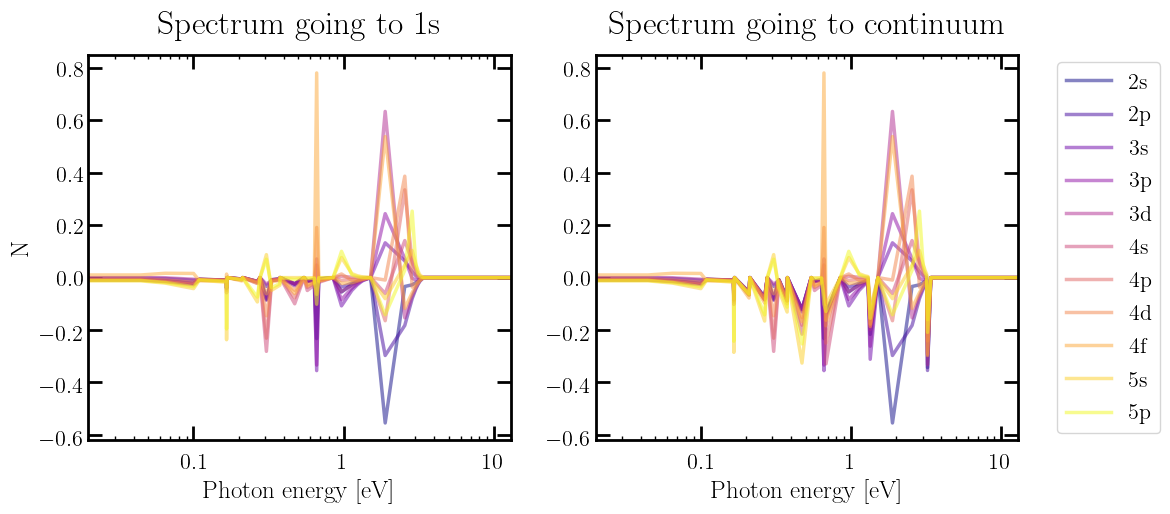

In [616]:
# Plot the spectra?
nl_to_plot = range(1, 12) # Plot range of nl
# nl_to_plot = np.where(nonzero_l==0)[0][1:] # Plot specific l
# nl_to_plot = [1]
spectroscopic = ['s', 'p', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
colors = cm.plasma(np.linspace(0,1,len(nl_to_plot)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.set_xscale('log')
ax2.set_xscale('log')

for i, nl in enumerate(nl_to_plot):
#    ax1.plot(photeng[70:160], dndw_1s[nl-1,70:160], 
    ax1.plot(photeng, dndw_1s[nl-1], 
                color=colors[i], alpha=0.5,
                label=f'{nonzero_n[nl]}'+spectroscopic[nonzero_l[nl]])
#    ax2.plot(photeng[70:160], dndw_Cont[nl-1,70:160], 
    ax2.plot(photeng, dndw_Cont[nl-1], 
                color=colors[i], alpha=0.5,
                label=f'{nonzero_n[nl]}'+spectroscopic[nonzero_l[nl]])
    
ax1.set_xlim(0.02,13)
#ax1.set_ylim(1e-8,4)
ax1.set_xlabel('Photon energy [eV]')
ax1.set_ylabel('N')
ax1.set_title('Spectrum going to 1s')

ax2.set_xlim(0.02,13)
#ax2.set_ylim(1e-8,4)
ax2.legend(bbox_to_anchor=(1.04,1.04), loc="upper left")
ax2.set_xlabel('Photon energy [eV]')
ax2.set_title('Spectrum going to continuum')

Text(0.5, 1.0, 'Spectrum going to continuum')

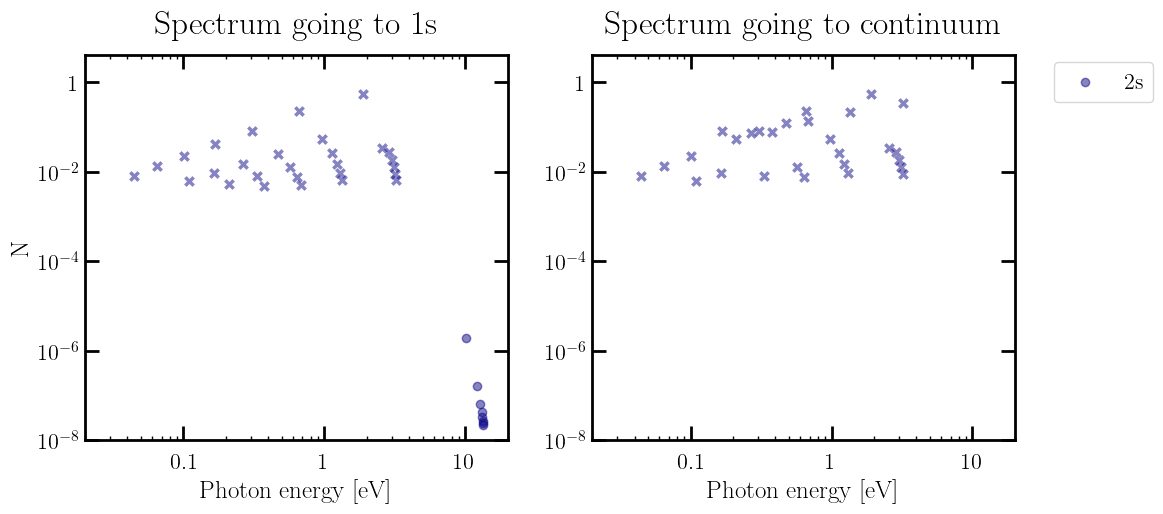

In [617]:
# Plot the spectra?
nl_to_plot = range(1, 2) # Plot range of nl
# nl_to_plot = np.where(nonzero_l==0)[0][1:] # Plot specific l
# nl_to_plot = [1]
spectroscopic = ['s', 'p', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
colors = cm.plasma(np.linspace(0,1,len(nl_to_plot)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.loglog()
ax2.loglog()

for i, nl in enumerate(nl_to_plot):
    ax1.scatter(photeng[dndw_1s[nl-1]>0], dndw_1s[nl-1,dndw_1s[nl-1]>0], 
                color=colors[i], alpha=0.5,
                label=f'{nonzero_n[nl]}'+spectroscopic[nonzero_l[nl]])
    ax1.scatter(photeng[dndw_1s[nl-1]<0], -dndw_1s[nl-1,dndw_1s[nl-1]<0], 
                color=colors[i], alpha=0.5, marker='x')
    ax2.scatter(photeng[dndw_Cont[nl-1]>0], dndw_Cont[nl-1,dndw_Cont[nl-1]>0], 
                color=colors[i], alpha=0.5,
                label=f'{nonzero_n[nl]}'+spectroscopic[nonzero_l[nl]])
    ax2.scatter(photeng[dndw_Cont[nl-1]<0], -dndw_Cont[nl-1,dndw_Cont[nl-1]<0], 
                color=colors[i], alpha=0.5, marker='x')
    
ax1.set_xlim(0.02,20)
ax1.set_ylim(1e-8,4)
ax1.set_xlabel('Photon energy [eV]')
ax1.set_ylabel('N')
ax1.set_title('Spectrum going to 1s')

ax2.set_xlim(0.02,20)
ax2.set_ylim(1e-8,4)
ax2.legend(bbox_to_anchor=(1.04,1.04), loc="upper left")
ax2.set_xlabel('Photon energy [eV]')
ax2.set_title('Spectrum going to continuum')

In [618]:
test_nl = 1

#Check fraction of paths containing a photon corresponding to deexcitation to ground state
print('Fraction of paths w/ a photon going to 1s:  ', np.sum(dndw_1s[test_nl,photeng>6]) / Pto1s_many[test_nl])
print('\n')

#Check energy conservation going to 1s
print('To 1s')
print('Energy in spectrum:   ', np.sum(dndw_1s[test_nl]*photeng) / Pto1s_many[test_nl])
print('Energy of transition: ', phys.rydberg*(1-1/nonzero_n[test_nl]**2))
print('\n')

#Check energy conservation going to continuum
print('To continuum')
print('Energy in spectrum:   ', np.sum(dndw_Cont[test_nl]*photeng) / PtoCont_many[test_nl])
print('Energy of transition: ', -phys.rydberg/nonzero_n[test_nl]**2)

Fraction of paths w/ a photon going to 1s:   0.9999999999999999


To 1s
Energy in spectrum:    -1299124.2735230597
Energy of transition:  10.204269397500001


To continuum
Energy in spectrum:    -3.284191698369994
Energy of transition:  -3.4014231325
